# Link prediction with GraphSAGE - stellargraph & tensorflow

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 9.8 MB/s 
     |████████████████████████████████| 482 kB 57.7 MB/s 
     |████████████████████████████████| 41 kB 541 kB/s 


In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [33]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

## Load data

In [20]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
COLAB = True

Mounted at /content/drive


In [24]:
import os
import pandas as pd
os.chdir('/content/drive/MyDrive/data/aesthetics') 

In [47]:
df_links=pd.read_csv('annotated_links.csv',names=['source','target','k'])
df_links=df_links.drop('k', axis=1)
df_links.head()

,source,target
0,ae4j.png,ae4h.png
1,ae4j.png,ae5b.png
2,ae6f.png,ae6a.png
3,ae4e.png,ae4d.png
4,ae5a.png,ae5c.png


In [43]:
df_nodes=pd.read_csv('colours.csv').set_index('ImgName')
df_nodes.head()

,steel,burnt siena,pink,dark brown,seagreen,lightskyblue,vomit yellow,bright violet,denim blue,ugly pink,...,seafoam blue,kiwi,light turquoise,washed out green,light bright green,cool grey,brown yellow,purply pink,greyish green,purple
ImgName,,,,,,,,,,,,,,,,,,,,,
ae1c.png,0.00,0.2,0.86,1.60,0.00,0.00,0.0,0,0.00,2.88,...,0.00,0.0,0.0,0.76,0,1.91,0.0,0,1.00,0
ae1b.png,2.70,0.0,3.33,1.00,0.45,0.77,0.0,0,1.40,1.79,...,1.48,0.0,0.0,0.96,0,3.47,0.0,0,1.50,0
ae1a.png,0.00,0.0,3.15,0.93,0.00,0.00,0.0,0,0.00,2.77,...,0.00,0.0,0.0,0.35,0,1.54,0.0,0,1.18,0
ae1d.png,1.29,0.0,3.45,0.75,0.00,0.00,0.0,0,0.97,2.13,...,0.00,0.0,0.0,0.45,0,1.79,0.0,0,0.37,0
ae5h.png,1.25,0.0,1.42,2.00,0.56,0.00,0.0,0,0.81,1.71,...,0.00,0.0,0.0,0.00,0,2.68,0.0,0,0.69,0


In [48]:
G = sg.StellarGraph(df_nodes, df_links)

In [49]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 44, Edges: 177

 Node types:
  default: [44]
    Features: float32 vector, length 100
    Edge types: default-default->default

 Edge types:
    default-default->default: [177]
        Weights: all 1 (default)
        Features: none


In [50]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 17 positive and 17 negative edges. **


In [51]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 16 positive and 16 negative edges. **


Summary of G_train and G_test - (same set of nodes,  differing edges)

In [52]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 44, Edges: 144

 Node types:
  default: [44]
    Features: float32 vector, length 100
    Edge types: default-default->default

 Edge types:
    default-default->default: [144]
        Weights: all 1 (default)
        Features: none


In [53]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 44, Edges: 160

 Node types:
  default: [44]
    Features: float32 vector, length 100
    Edge types: default-default->default

 Edge types:
    default-default->default: [160]
        Weights: all 1 (default)
        Features: none


In [54]:
batch_size = 20
epochs = 20

In [55]:
num_samples = [20, 10]

In [56]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [57]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [58]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

In [59]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = graphsage.in_out_tensors()

In [60]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [61]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [62]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2/2 [==============================] - 0s 20ms/step - loss: 0.9937 - acc: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 1.0522
	acc: 0.5625

Test Set Metrics of the initial (untrained) model:
	loss: 0.9937
	acc: 0.5000


Training

In [63]:
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, verbose=2)

Epoch 1/20
2/2 - 2s - loss: 0.6472 - acc: 0.5938 - val_loss: 0.9786 - val_acc: 0.5000 - 2s/epoch - 855ms/step
Epoch 2/20
2/2 - 0s - loss: 0.7387 - acc: 0.5312 - val_loss: 0.9562 - val_acc: 0.5000 - 159ms/epoch - 79ms/step
Epoch 3/20
2/2 - 0s - loss: 0.6764 - acc: 0.6562 - val_loss: 0.9225 - val_acc: 0.5294 - 156ms/epoch - 78ms/step
Epoch 4/20
2/2 - 0s - loss: 0.7315 - acc: 0.6250 - val_loss: 0.9252 - val_acc: 0.5294 - 154ms/epoch - 77ms/step
Epoch 5/20
2/2 - 0s - loss: 0.6235 - acc: 0.6562 - val_loss: 0.9170 - val_acc: 0.5294 - 157ms/epoch - 79ms/step
Epoch 6/20
2/2 - 0s - loss: 0.7486 - acc: 0.5000 - val_loss: 0.8986 - val_acc: 0.5000 - 165ms/epoch - 82ms/step
Epoch 7/20
2/2 - 0s - loss: 0.6374 - acc: 0.5625 - val_loss: 0.8819 - val_acc: 0.5294 - 162ms/epoch - 81ms/step
Epoch 8/20
2/2 - 0s - loss: 0.7028 - acc: 0.6875 - val_loss: 0.8631 - val_acc: 0.5000 - 158ms/epoch - 79ms/step
Epoch 9/20
2/2 - 0s - loss: 0.6717 - acc: 0.5938 - val_loss: 0.8868 - val_acc: 0.5000 - 161ms/epoch - 80ms

Plot the training history:

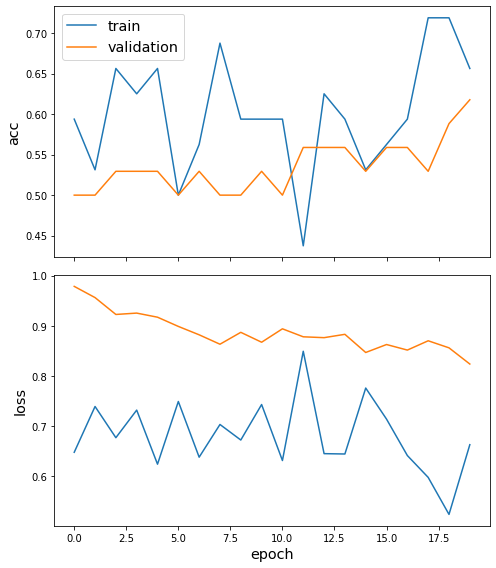

In [64]:
sg.utils.plot_history(history)

Evaluate the trained model on test links:

In [65]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2/2 [==============================] - 0s 18ms/step - loss: 0.8398 - acc: 0.5882

Train Set Metrics of the trained model:
	loss: 0.8306
	acc: 0.6250

Test Set Metrics of the trained model:
	loss: 0.8398
	acc: 0.5882
